In [4]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz, square
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn
# set the seed
np.random.seed(2)

## Match filter on regular sampling:
* Since we have a regular sampling there is no problem with the frequencies of the dictionary or the nyquist frequency, this allow us to use an easy procedure for the match filter method for the fourier dictionary and with this, we will use the fast fourier algorithm.

## Cases
* We are going to consider different cases in order to see how this method will work, this cases are:
    * Signal only of white noise
    * Signal of a sinusoid plus white noise
    * Signal of a composition of sinusoids plus white noise

## Creating the signal

In [5]:
class Signal:
    def __init__(self, frequencies=[1], weights=[1], noise=None):
        """
        it will generate a signal usign the frequencies and the weight from input.
        the frecuencies should be in Hertz and the weight is a constante of "amplitud" 
        of every sub-signal associated to avery frequency.
        weight should be a number between 0 and 1
        """
        self.frequencies = frequencies
        self.weights = weights
        self.noise = noise
        self.amp = 1
    
    def noise_samples(self):
        return self.noise
    
    def sin_samples(self, times, with_noise=False):
        y = np.zeros(times.shape[-1])
        for i in range(len(self.frequencies)):
            y += self.weights[i] * np.sin(2 * np.pi * self.frequencies[i] * times)
        if with_noise:
            y += self.noise
        return self.amp * y
    
    def square_samples(self, times, with_noise=False):
        y = np.zeros(len(times))
        for i in range(len(self.frequencies)):
            y += self.weights[i] * np.sign(np.sin(2 * np.pi * self.frequencies[i] * times))
        if with_noise:
            y += self.noise
        return self.amp * y
    
    def gaussian_samples(self):
        pass
    
# also is insteresting to see how te ASD of a signal or template is, for this we do:
def get_asd(data, fs):
    psd, freq = mlab.psd(data, Fs=fs, NFFT=4*fs)
    return np.sqrt(np.abs(psd)), freq

## Whitening method:
* Some signals could be "colored", which means, that there is a noise fluctuaction much larger in some parts, in order to supress this extra fluctuation in noise, we do the "whitening", this allows us to see weak signals that before we couldn't see.

    To "whiten" a signal we divide it by the noise amplitude spectrum, in the fourier domain. And the resulting time series change his units to "sigmas" away from the mean.
    
    One simple example is a signal of only noise, this rough signal of noise could be misunderstood if we do not clear the high noises, this will be seen on the case 1.

In [6]:
# whitening
class Whitening:
    def __init__(self, data, fs):
        self.data = data
        self.fs = fs
        self.dt = 1 / self.fs
        self.freqs = np.fft.rfftfreq(len(self.data), self.dt)
    
    def whiten(self, noise=None):
        fft_data = np.fft.rfft(self.data)
        norm = 1./np.sqrt(1./(self.dt*2)) # normalized by the nyquist frequency(?)
        if noise is not None:
            psd = self.make_psd(noise)
        else:
            # usually the noise is much higher than the signal so the psd of the entire
            # signal is approx. the psd of the noise.
            psd = self.make_psd(self.data)
        white_fft_data = fft_data / np.sqrt(np.abs(psd)) * norm
        white_data = np.fft.irfft(white_fft_data, n=len(self.data))
        return white_data
    
    def make_psd(self, data):
        power, freq = mlab.psd(data, Fs=self.fs, NFFT=4 * self.fs)
        return np.interp(self.freqs, freq, power)

## The Match Filter method:
* The idea is to make the convolution between the signal and a template, using the fourier transform allow us to make easy the convolution. The procedure is:
    * First make the fourier transform of the signal and template
    * do the product and scale for the power spectral density of the noise
    * then go back to the time domain in order to se how is the SNR for different matches across time.
    * find the best SNR, i.e. the SNR when the template and the signal match the best while we are "moving" the template across time.

In [11]:
# Match_filter
class MatchFilter:
    def __init__(self, data, template, dt, alpha=0.5):
        self.dt = dt
        self.df = 2 * np.pi / len(data)
        self.data = data
        self.template = template
        self.freqs = self.compute_freqs()
        self.dwindow = signal.tukey(template.size, alpha=alpha)
        
    def compute_freqs(self):
        return np.fft.fftfreq(self.template.size) * self.df
    
    def make_psd(self, data):
        NFFT = 2 * len(data)
        psd_window = np.blackman(NFFT)
        # and a 50% overlap:
        NOVL = NFFT/2
        power, freq = mlab.psd(data, Fs=1/self.dt, NFFT=NFFT, window=psd_window, noverlap=NOVL)
        self.freq_psd = freq
        self.psd = power
        print("lenght of datas before: {} and after {}".format(len(power), len(np.interp(np.abs(self.freqs), freq, power))))
        return np.interp(np.abs(self.freqs), freq, power)
    
    def product(self, data_fft, template_fft, power_vec):
        print(max(data_fft), max(template_fft), min(data_fft), min(template_fft), max(power_vec))
        return data_fft * template_fft.conjugate() / power_vec 
    
    def make_fft(self, noise):
        template_fft = np.fft.fft(self.template * self.dwindow)
        data_fft = np.fft.fft(self.data * self.dwindow)
        power_vec = self.make_psd(noise)
        return template_fft, data_fft, power_vec
        
    def SNR(self, noise, normalize=True, shift=True): # as defined from LIGO
        template_fft, data_fft, power_vec = self.make_fft(noise)
        optimal = 4 * 2 * np.pi * self.df * np.fft.ifft(self.product(data_fft, template_fft, power_vec))
        print(max(abs(optimal)))
        # in order to get an SNR of 1 when the template is at a time of where the signal is only noise,
        # we divide by this sigma:
        if normalize:
            sigmasq = 4 * ((template_fft * template_fft.conjugate() / power_vec).real).sum() * self.df
            sigma = np.abs(sigmasq)
            print("sigma is: {}".format(sigma))
        else:
            sigma = 1
            
        SNR_complex = np.sqrt(optimal / sigma)
        print(max(abs(SNR_complex)))
        # this wil give us an array of matches between the signal and the template representing
        # the offset in time, this mean that we will get the maximun SNR at offset 0 and the same value at the end
        # of the array (maximun offset), this is because is cyclical, so in order to get the maximun SNR at an
        # offset of time between the minimum (offset 0) and maximum, we move the template peak to the end and since we usually
        # have the peak of the template at the middle of time, we do:
        if shift:
            peaksample = int(self.template.size / 2)  # location of peak in the template
            SNR_complex = np.roll(SNR_complex,peaksample) # we shift the SNR because we want to shift the time of the template.
            
        return abs(SNR_complex)

### Testing for White noise
* No matter what template whe try here there should be always a bad SNR. Here we are going to see how important is the whitening for this procedure. First we do the match filter for the rough data and then we do the same process to the whiten data.

the low frequency is: 0.24986111111111112
lenght of datas before: 1801 and after 1800
lenght of datas before: 1801 and after 1800
(154.67740309874017+42.07873964532363j) (121.26279498260294+0j) (-124.24258220542103-68.13273109207026j) (-119.81483307658758-0.7343263733350469j) 0.025698374248161748
338.43101232311466
sigma is: 92259.65204907651
0.060566038785048126
the mean SNR is: 0.01888136462398935


/home/AstroPancho/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


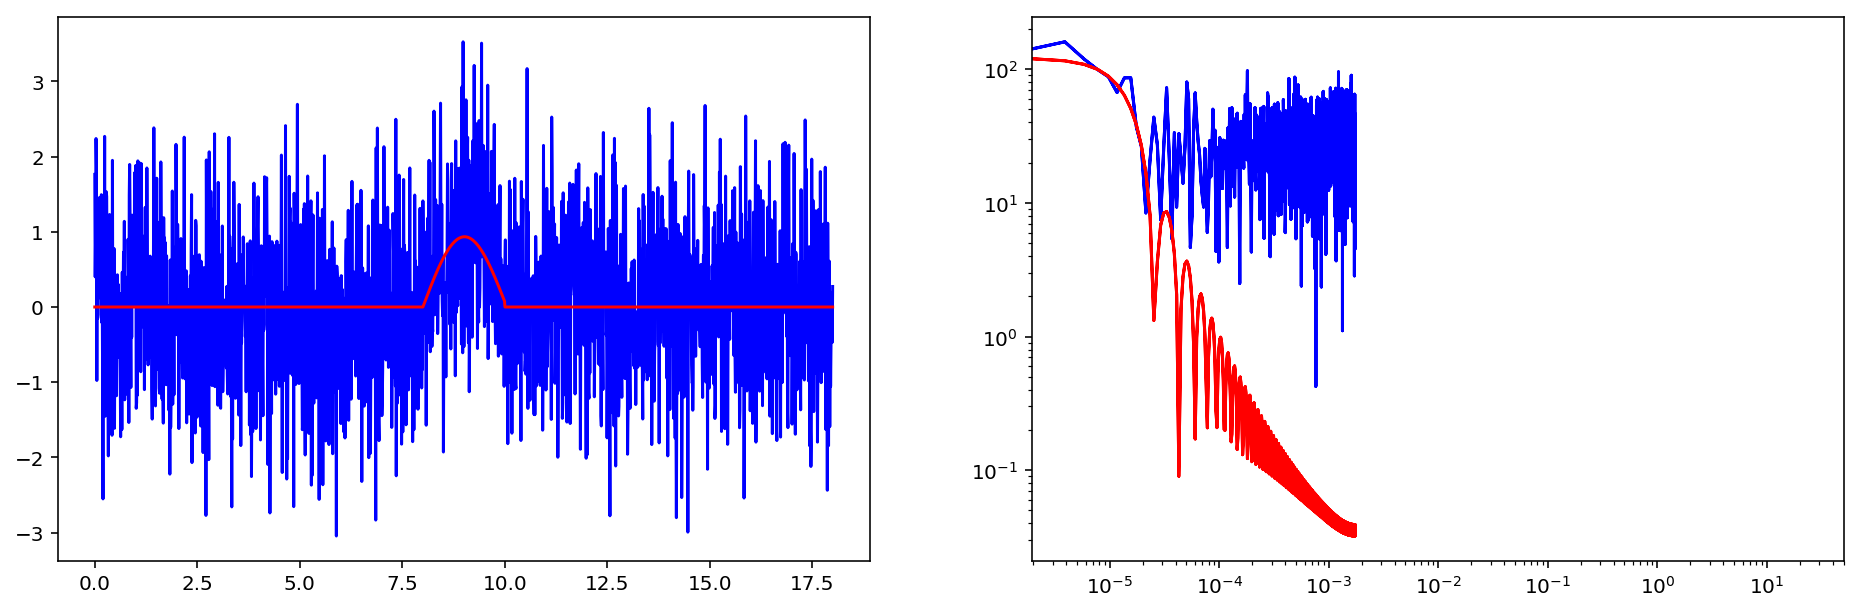

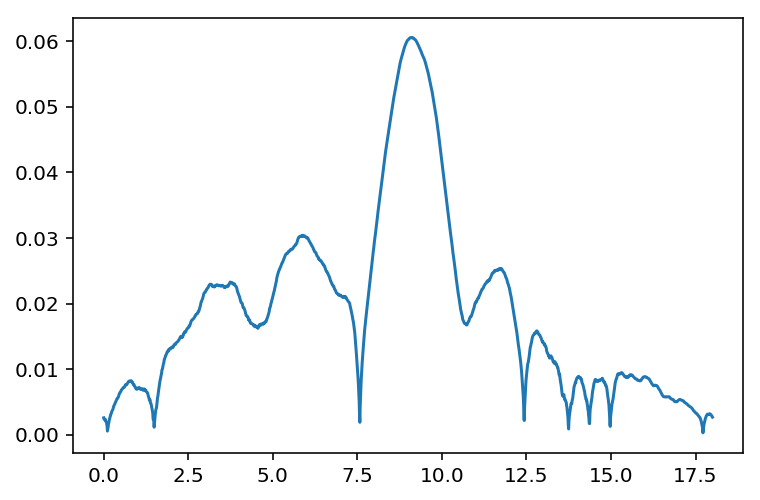

In [12]:
dt = 0.01        # time interval
N = 1800         # number of samples
T = N * dt       # duration [s]
np.random.seed(0)  # set the seed

# time array
times = np.linspace(0, N * dt, N)

# generate the noise
noise =  np.random.normal(0, 1, len(times))

# here the signal is noise
data = noise

# generate the template
template = np.zeros(len(times))
# setting the low frequency
low_f = 0.5 / times[int(len(times) / 9)]
print("the low frequency is: {}".format(low_f))
# two options to check template, one completely sinusoidal and another with just one peak
template[int(len(times)*4/9): int(len(times)*5/9)] = Signal(frequencies=[low_f, 100], 
                                                          weights=[0.9, 0.1]).sin_samples(times[0:int(len(times)*1/9)], 
                                                                                          with_noise=False)
# template = Signal(frequencies=[low_f, 300], weights=[0.9, 0.1]).sin_samples(times, with_noise=False)

data = noise + template
# do the match filter
mf = MatchFilter(data, template, dt)
template_fft, data_fft, power_vec = mf.make_fft(data)
freqs = mf.compute_freqs()
snr = mf.SNR(data, normalize=True, shift=True)


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 5))
ax1.plot(times, data, 'b')
ax1.plot(times, template, 'r')
ax2.loglog(abs(freqs), abs(data_fft), 'b')
ax2.loglog(abs(freqs), abs(template_fft.conjugate()), 'r')
ax2.set_xlim(0, 50)

fig = plt.figure()
plt.plot(times, snr)
print("the mean SNR is: {}".format(np.mean(snr)))

# fig = plt.figure()
# plt.plot(mf.freq_psd, mf.psd)
# print("average one-sided PSD is: {}".format(np.average(mf.psd)))

No handles with labels found to put in legend.


lenght of datas before: 51 and after 1800
(154.67740309874017+42.07873964532363j) (121.26279498260294+0j) (-124.24258220542103-68.13273109207026j) (-119.81483307658758-0.7343263733350469j) 0.027195964993297322
14732.760434362719
sigma is: 1672.808825276115
8.807199132232531


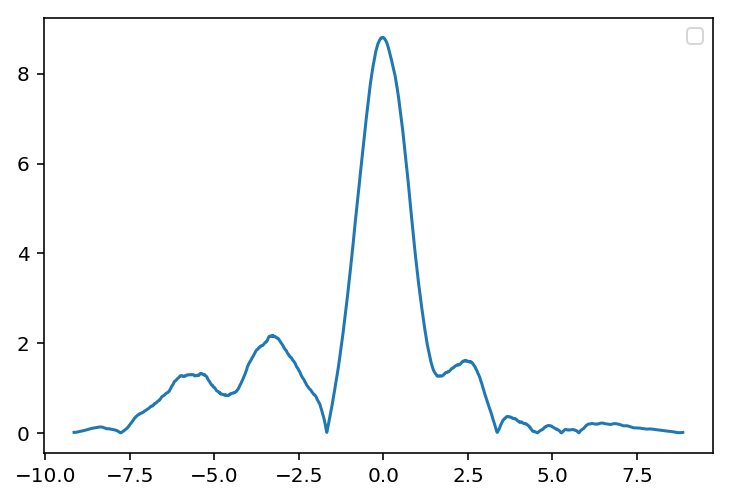

In [42]:
mf = MatchFilter(data, template, dt)
snr = mf.SNR(noise, normalize=True, shift=True)

 # find the time and SNR value at maximum:
indmax = np.argmax(snr)
timemax = times[indmax]
SNRmax = snr[indmax]
plt.plot(times - timemax, snr)
plt.legend()

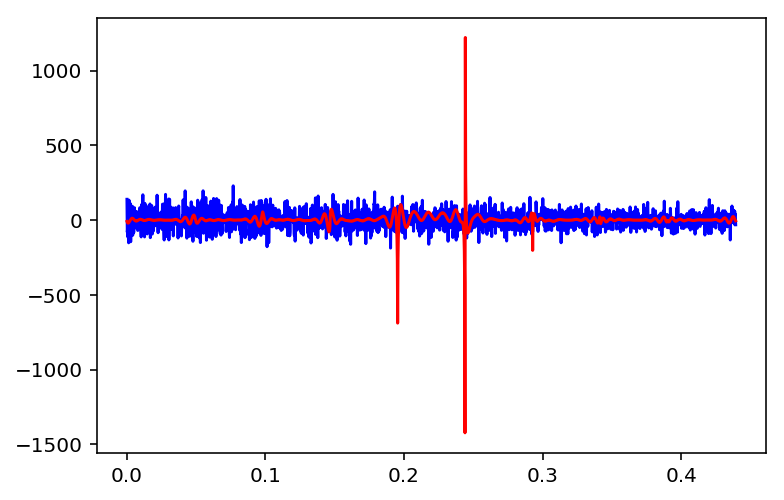

In [7]:
data2 = Whitening(data, fs).whiten()
noise2 = Whitening(noise, fs).whiten()
template2 = Whitening(template, fs).whiten()
plt.plot(times, data2, 'b')
plt.plot(times, template2, 'r')
# plt.xlim(0.2, 0.4)

(9729.907011197976+8249.196419159269j) (3694.15015970528-15.673102863452613j) (-8788.198637318248-5499.885176745311j) (-4579.469629117024-5244.358930155857j) 0.006010330620747967
37392189400.12903
sigma is: 43944243.38102357
850.9007442889798
193.6603390396182
average one-sided PSD is: 0.00017107701122210783


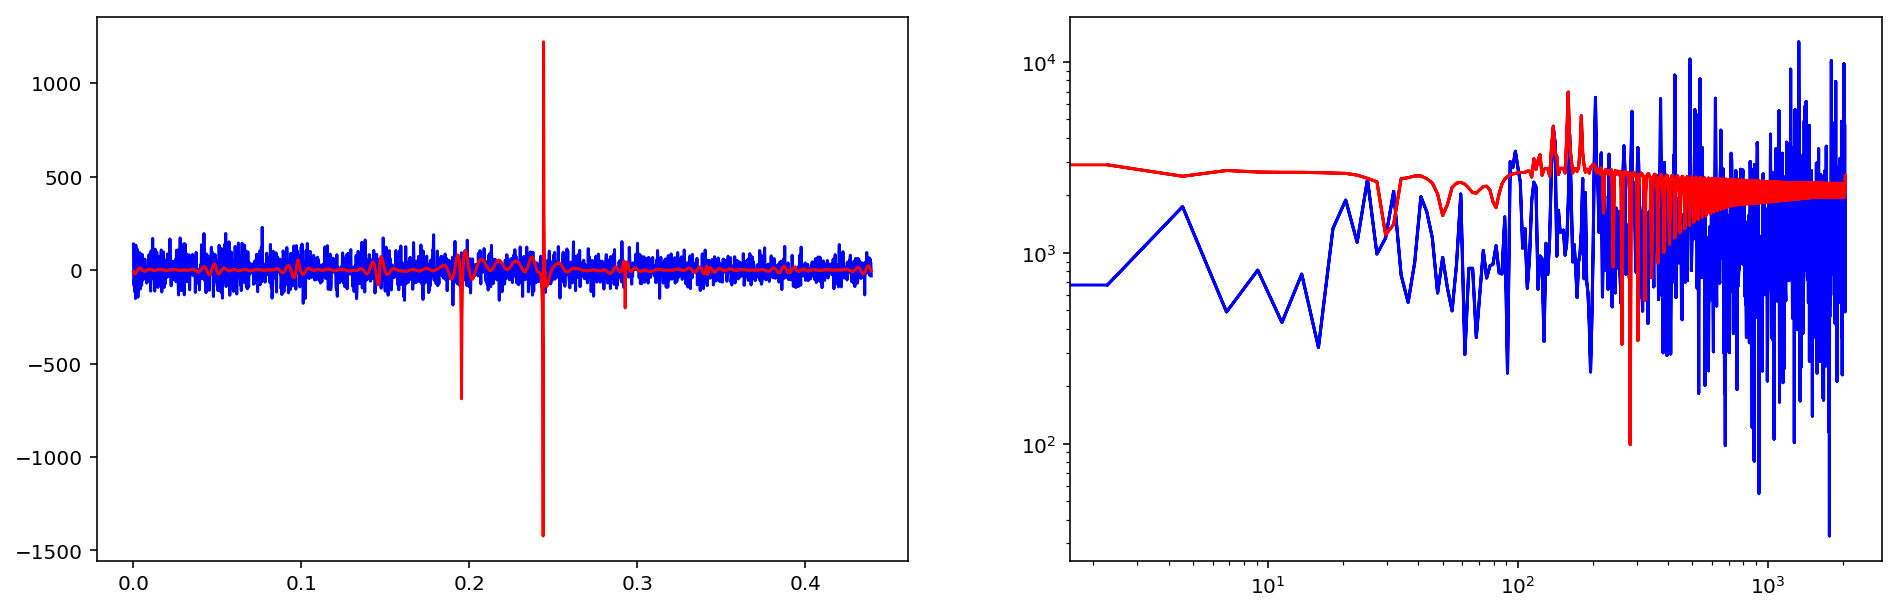

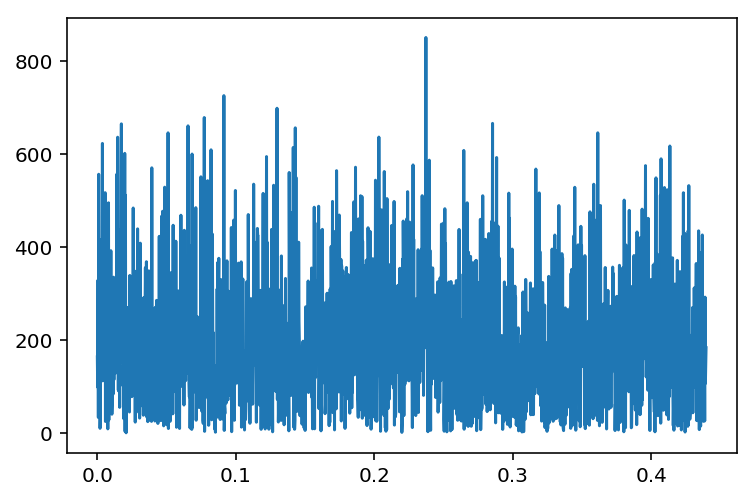

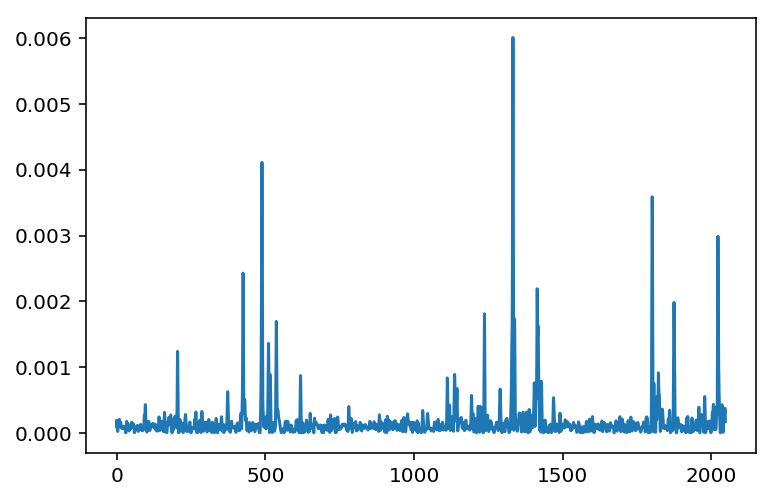

In [8]:
mf = MatchFilter(data2, template2, dt)
template_fft, data_fft, power_vec = mf.make_fft(noise2)
freqs = mf.compute_freqs()
snr = mf.SNR(noise2, normalize=True, shift=True)


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 5))
ax1.plot(times, data2, 'b')
ax1.plot(times, template2, 'r')
ax2.loglog(abs(freqs), abs(data_fft), 'b')
ax2.loglog(abs(freqs), abs(template_fft.conjugate()), 'r')
# ax2.set_xlim(0, 50)

fig = plt.figure()
plt.plot(times, snr)
print(np.mean(snr))

fig = plt.figure()
plt.plot(mf.freq_psd, mf.psd)
print("average one-sided PSD is: {}".format(np.average(mf.psd)))

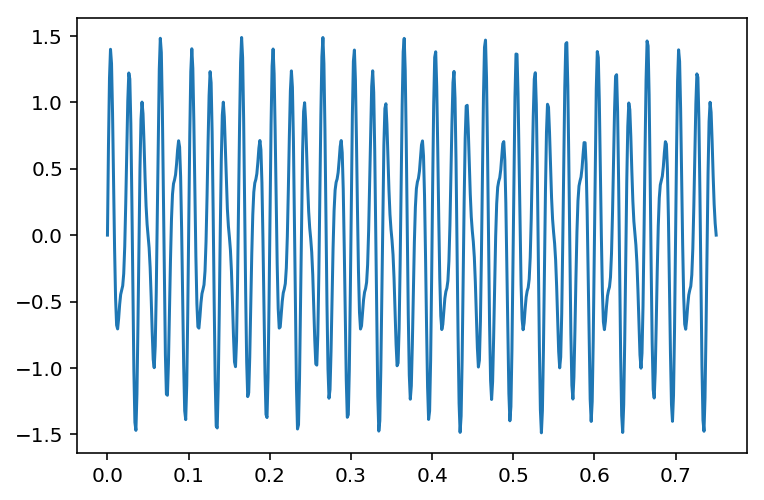

In [9]:
import scipy.fftpack

# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
plt.plot(x, y)

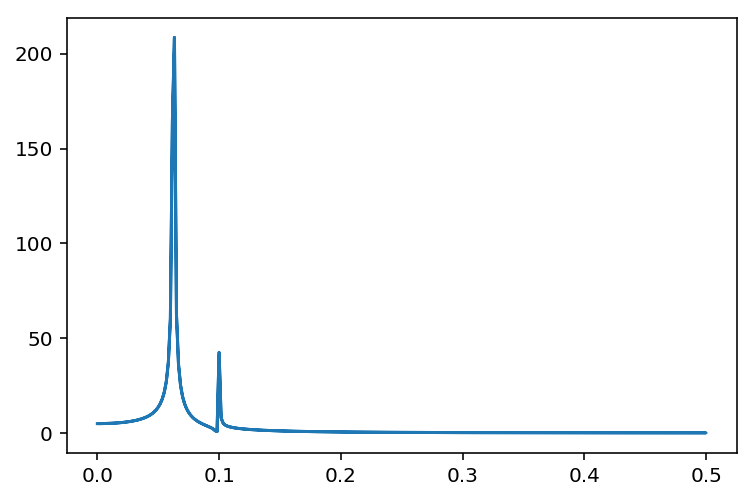

In [10]:
yf = np.fft.fft(y)
xf = np.fft.fftfreq(len(y))
plt.plot(abs(xf), abs(yf.real))

In [11]:
a = data_fft[:4]
b = template_fft[:4].conjugate()
c = power_vec[:4]
print(a)
print(b)
print(c)
print(a * b / c)
print(((b * b.conjugate() / c)))

[ 1993.13747628   +0.        j    -6.38728419 +678.05363175j
 -1374.27389757-1076.52629483j    42.08919878 -488.23988928j]
[ 3482.58499018 -0.        j -2891.45648027 +9.5545733 j
  2518.8774606 -17.08696191j -2700.16749958+25.29256738j]
[9.65965163e-05 7.08728371e-05 3.82588314e-05 1.38852108e-04]
[ 7.18583954e+10+0.00000000e+00j  1.69176819e+08-2.76639637e+10j
 -9.09599687e+10-7.02623565e+10j -7.29546335e+08+9.50215337e+09j]
[1.25557305e+11+0.j 1.17966378e+11+0.j 1.65844993e+11+0.j
 5.25130252e+10+0.j]


In [12]:
a[2].conjugate()

(-1374.2738975746938+1076.5262948329016j)

In [13]:
a[2]

(-1374.2738975746938-1076.5262948329016j)

In [14]:
(a[2].conjugate() * a[2])

(3047537.6090217954+0j)

In [15]:
a[2].real ** 2 + a[2].imag ** 2

3047537.6090217954

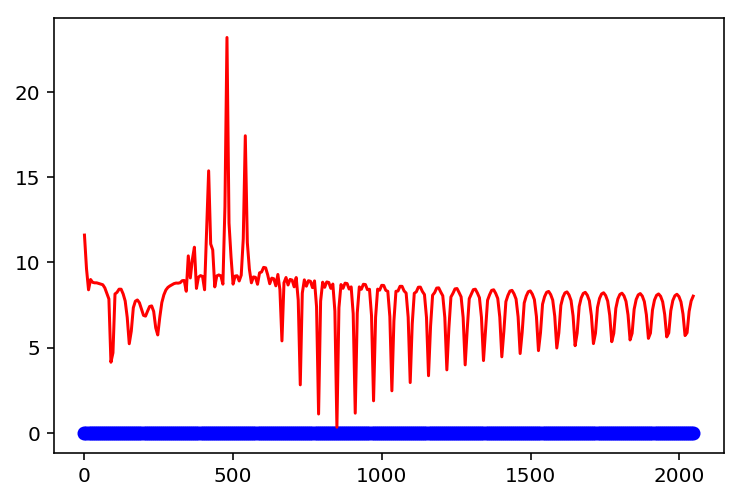

In [16]:
yf = scipy.fftpack.fft(template) / fs
xf = np.linspace(0.0, 1.0/(2.0*dt), int(N/2))
plt.plot(xf, 2.0/N * np.abs(yf[:int(N/2)]), '-ob')
plt.plot(xf,  2.0/N * np.abs(template_fft[:int(N/2)]), 'r')

In [17]:
yf[:4] / fs

array([ 6.84161280e-06+0.00000000e+00j, -6.76263431e-06-2.31173100e-08j,
        6.52967898e-06+4.33792958e-08j, -6.15442638e-06-5.82708703e-08j])

In [ ]:
# class ManualMatchFilter:
#     def __init__(self, data, template, dt):
#         self.dt = dt
#         self.fs = int(1 / dt)
#         self.data = data
#         self.template = template
#         self.N = len(self.data)
#         self.freqs = self.compute_freqs()
        
#     def expo(i, k):
#         return np.exp(2j * np.pi * i * k / self.N)
    
#     def fft_data(k):
#         suma = 0
#         for i in range(0, self.N-1):
#             suma += self.data[i] * self.expo(i, k)
#         return self.dt * suma
    
#     def fft_template(k):
#         suma = 0
#         for i in range(0, self.N-1):
#             suma += self.template[i] * self.expo(i, k)
#         return self.dt * suma
    
#     def hann_window():
#         return signal.hann(self.N)
    
#     def W():
#         suma = 0
#         hann = self.hann_window()
#         for i in range(0, self.N - 1):
#             suma += (self.data[i] * hann) ** 2
#         return suma / self.N
    
#     def get_df():
#         # the nyquist freq is:
#         nyq = 0.5 / self.dt
#         # y tenemos que, en el caso de ser N par:
#         df = 2 * nyq / self.N
#         return df
    
#     def periodogram_sum(k):
#         suma = 0
#         w = self.data * self.hann_window()
#         for j in range(0, self.N-1):
#             suma += self.data[j] * w[j] * self.expo(-i, k)
#         return suma
    
#     def normalized_peridogram(k):
#         return (2 * self.get_df() / self.W()) * abs(self.dt() * self.periodogram_sum(k)) ** 2
    
#     def average_power_spectrum(k):
#         suma = 0
#         for n in ()